In [2]:
# download the data, data should be moved to "data/"
# https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/review-California.json.gz
# https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-California.json.gz 

In [10]:
# all necesary imports
import numpy as np
import pandas as pd
import pandas as pd
import requests
import gzip
import json
import math
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Introduction

TODO: Advaith

# Dataset

The data set is taken from Jiacheng Li et el (2022) [1] and An Yan et el [2] whihc contains review information from Google Maps (ratings, text, images, etc) and business metadata (address, geographic info, descriptions, category information, price, open hours, etc.), and links (related businesses) up to Sep 2021 in the United States. The full dataset consists of **666,324,103 Reviews, 113,643,107 Users and 4,963,111 Businesses**. Due to storage constraints for a class project, we are taking a subset of this dataset by constraining the location to only california. The california dataset consists of:

1. 1,504,347 Reviews (0.22% of the full dataset)
2. XXXXX Users (% of the full dataset)
3. 21,507 businesses (0.43% of the full dataset)

For each review, we have the following information

1. **user_id** - ID of the reviewer
2. **name** - name of the reviewer
3. **time** - time of the review (unix time)
4. **rating** - rating of the business
5. **text** - text of the review
6. **pics** - pictures of the review
7. **resp** - business response to the review including unix time and text of the response
8. **gmap_id** - ID of the business

For eah business, we have a metadata file with the following information

1. **name** - name of the business
2. **address** - address of the business
3. **gmap_id** - ID of the business
4. **description** - description of the business
5. **latitude** - latitude of the business
6. **longitude** - longitude of the business
7. **category** - category of the business
8. **avg_rating** - average rating of the business
9. **num_of_reviews** - number of reviews
10. **price** - price of the business
11. **hours** - open hours
12. **MISC** - MISC information
13. **state** - the current status of the business (e.g., permanently closed)
14. **relative_results** - relative businesses recommended by Google
15. **url** - URL of the business

[1]: https://arxiv.org/abs/2202.13469
[2]: https://arxiv.org/abs/2207.00422

### Data Cleaning

#### Dataset Download

In [4]:
def get_data(url):
    """
    Downloading the data from the url in .json.gz format
    and reads it into an array
    """

    dataset = []

    response = requests.get(url, stream=True)
    with gzip.GzipFile(fileobj=response.raw) as f:
        for line in f:
            data = json.loads(line)
            dataset.append(data)  

    return dataset

# Defining URLs
url_review_data = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/review-Hawaii_10.json.gz"
url_metadata = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-Hawaii.json.gz"

# Get data
dataset = get_data(url_review_data)
metadata = get_data(url_metadata)


print(f"Total reviews: {len(dataset)}")
print()
print(f"Total business: {len(metadata)}")

Total reviews: 1504347

Total business: 21507


#### Data Wrangling

In [5]:
# ----- Helper functions -----

def compute_tf_idf(dataframe: pd.DataFrame, column: str = "text") -> dict:
    """
    Compute TF-IDF for the specified column in the given dataframe.
    
    Args:
        dataframe (pd.DataFrame): The input dataframe containing the text data.
        column (str): The column on which to compute TF-IDF. Default is "text".

    Returns:
        dict: A dictionary where keys are document indices and values are dictionaries of word TF-IDF scores.
    """
    tokenized_text = dataframe[column].fillna("").apply(lambda x: x.split())

    tf = []
    for doc in tokenized_text:
        word_count = defaultdict(int)
        for word in doc:
            word_count[word] += 1
        doc_tf = {word: count / len(doc) for word, count in word_count.items()}
        tf.append(doc_tf)

    df = defaultdict(int)
    total_docs = len(tokenized_text)
    for doc in tokenized_text:
        unique_words = set(doc)
        for word in unique_words:
            df[word] += 1

    idf = {word: math.log(total_docs / (1 + freq)) for word, freq in df.items()}

    tf_idf = {}
    for idx, doc_tf in enumerate(tf):
        doc_tf_idf = {word: tf_value * idf[word] for word, tf_value in doc_tf.items()}
        tf_idf[idx] = doc_tf_idf

    return tf_idf

def compute_k_frequent_tfidf(text: str, tf_idf_map: dict, k_init: int = 3) -> list:
    """
    Computes the top k tf-idf words based on frequency

    Args:
        text (str): text to decode
        tf_idf_map (dict): map of the tfidf for the text
        k_init (int): top k frequencies to return

    Returns:
        list of the top k tf-idfs

    """
    words = {}

    # error handling
    if text is None or len(text) == 0:
        return np.zeros(k_init).tolist() 
    
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\xa0', ' ')
    text = text.replace('\u3000', ' ')

    # text parsing
    for w in text.split(' '):
        if w not in list(words.keys()):
            words[w] = 1

        else:
            words[w] = words[w] + 1

    # sorting words
    sorted_words = {ky: v for ky, v in sorted(words.items(), key=lambda item: item[1])}

    k = k_init
    if k > len(sorted_words):
        k = len(sorted_words)

    # extracting top k tf_idfs
    tf_idfs = []
    for word in list(sorted_words.keys())[:k]:
        if len(word) == 0:
             tf_idfs.append(0)

        else:
            tf_idfs.append(tf_idf_map[word])

    while len(tf_idfs) != k_init:
        tf_idfs.append(0)

    return tf_idfs


In [6]:
# creating dataset as a pd.Dataframe
data = pd.DataFrame()
data['user_id'] = [d['user_id'] for d in dataset]
data['text'] = [d['text'] for d in dataset]
data['rating'] = [d['rating'] for d in dataset]
data['gmap_id'] = [d['gmap_id'] for d in dataset]

# setting map
gmap_map = {d['gmap_id']: d for d in metadata}

# adding lat long data and category
data['lat'] = [gmap_map[d['gmap_id']]['latitude'] for d in dataset]
data['long'] = [gmap_map[d['gmap_id']]['longitude'] for d in dataset]
data['category'] = [gmap_map[d['gmap_id']]['category'][0] if gmap_map[d['gmap_id']]['category'] is not None else 'None' for d in dataset]
data['days_open'] = [len(gmap_map[d['gmap_id']]['hours']) if gmap_map[d['gmap_id']]['hours'] is not None else -1 for d in dataset]
data['num_reviews'] = [gmap_map[d['gmap_id']]['num_of_reviews'] for d in dataset]
data['avg_rating'] = [gmap_map[d['gmap_id']]['avg_rating'] for d in dataset]

# computing tf_if data
tf_idf_map = compute_tf_idf(data)

freq_1 = []
freq_2 = []
freq_3 = []
for i, text in enumerate(data['text']):
    tfs = compute_k_frequent_tfidf(text, tf_idf_map[i])

    freq_1.append(tfs[0])
    freq_2.append(tfs[1])
    freq_3.append(tfs[2])

data['tfidf_1'] = freq_1
data['tfidf_2'] = freq_2
data['tfidf_3'] = freq_3

# data
data.head()

,user_id,text,rating,gmap_id,lat,long,category,days_open,num_reviews,avg_rating,tfidf_1,tfidf_2,tfidf_3
0,113965417079576625433,Great new upgrade,5,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,21.440345,-157.754347,Recreation center,7,18,4.1,0.885643,1.681949,2.602379
1,116655819137293331166,None,5,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,21.440345,-157.754347,Recreation center,7,18,4.1,0.000000,0.000000,0.000000
2,100834119994550070853,None,5,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,21.440345,-157.754347,Recreation center,7,18,4.1,0.000000,0.000000,0.000000
3,103207214144482097315,None,5,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,21.440345,-157.754347,Recreation center,7,18,4.1,0.000000,0.000000,0.000000
4,108526171163172578599,None,3,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,21.440345,-157.754347,Recreation center,7,18,4.1,0.000000,0.000000,0.000000


### Exploratory Data Analysis (EDA)

TODO: Ketki

In [33]:
# Geospatil plot
def plot_hawaii_with_ratings(data):
    # Extract latitude, longitude, and ratings from the data
    latitudes = [entry['latitude'] for entry in data]
    longitudes = [entry['longitude'] for entry in data]
    ratings = [entry['avg_rating'] for entry in data]
    
    # Set up the map
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-162, -153, 17, 23], crs=ccrs.PlateCarree())  # Hawaii bounding box

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.LAKES, color='blue', alpha=0.5)
    
    # Plot the points
    scatter = ax.scatter(
        longitudes,
        latitudes,
        c=ratings,
        cmap='Reds',
        s=[rating for rating in ratings],  # Scale size based on ratings
        edgecolor='black',
        alpha=0.7,
        transform=ccrs.PlateCarree()
    )
    
    # Add a color bar for ratings
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label('Average Rating')

    # Add title and labels
    plt.title("Hawaii Map with Ratings", fontsize=16)
    plt.show()

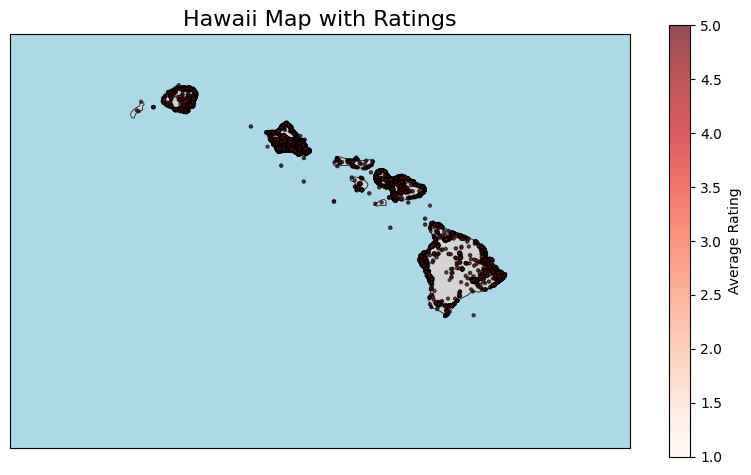

In [34]:
plot_hawaii_with_ratings(metadata)

# Predictive Task

### Research Question

The study aims to create a reccomender system to predict the rating a user will give to a partiucluar business (1 to 5). As the nature of the data is geospatial and reviews have sentiment associated with their text, the model must integrate these modalites. Therefore, We will model this in 2 ways:

1. Naive Modelling using TF-IDFs, average reviews, and location for a Decision Trees to create a baseline, and
2. Use Collaboritve Filtering, TF-IDFs of Text in reviews and Geospatial Information 

### Validation Method

TODO: Advaith

### Model

TODO: Arnav

# Results

TODO: Advaith, Arnav, Ketki

# Conclusion

TODO: Advaith

# Literature/Citation Work

TODO: Advaith